<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [570]:
%%capture
pip install pyswarms

In [571]:
%%capture
!pip install numpy==1.26

In [572]:
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [573]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [574]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

In [575]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [576]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [577]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [578]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [579]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [580]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [581]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [582]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [583]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario02.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario03.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario04.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [584]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [585]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [586]:
# Parâmetros do PSO
num_particles = 50
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

print("")
print("Melhores valores para λ, β, θ :", best_position)

2023-10-21 21:39:50,676 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2.16e-24
2023-10-21 21:39:51,145 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.1596670172218433e-24, best pos: [124.21621562   1.99695924   0.18959486]



Melhores valores para λ, β, θ : [124.21621562   1.99695924   0.18959486]


In [587]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 124.2162156207956
beta: 1.996959235993506
theta: 0.18959485740934434


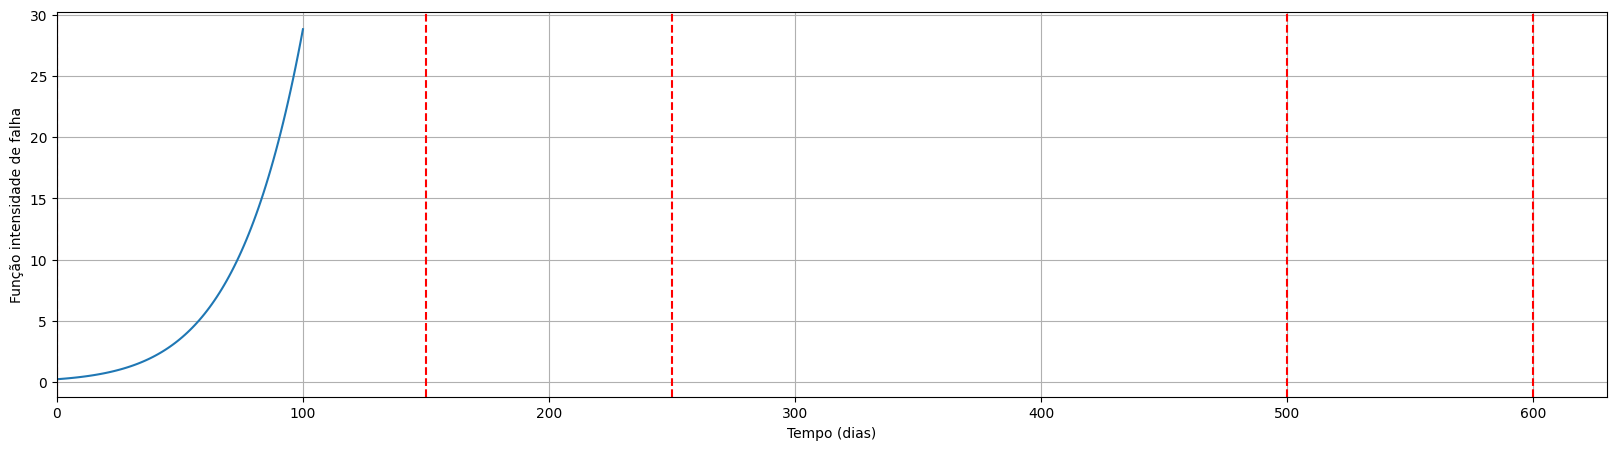

Fator ajuste:  [0.07303358418211803, 0.09044283401911923, 0.1568710538692326, 0.037209048745325046]


In [588]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [603]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [604]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-21 21:46:55,208 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=5.46e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 18, 67, 148, 157, 356, 374, 394, 428, 482, 523, 589, 630, 684, 690]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 4.204328918708185e-09, 0.0019031604220618311, 3.7889512831302476, 6.847000745381669, 24508.131730048663, 31273.898663452463, 43169.389043451476, 81805.87468818479, 242980.68551695938, 526105.5242614774, 3149445.9442199543, 6717412.388288854, 16037061.47610691, 17011904.24334103, 3944722.6880581044]
Custo =  2476574909.5643106


Número de ciclos de manutenção: 16 5
Tem

pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=5.46e+8<ipython-input-603-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=5.46e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 50, 225, 268, 321, 408, 476, 504, 512, 588, 601, 685, 712]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 4.204328918708185e-09, 9.895839184035804e-05, 279.558361285151, 1498.912307816827, 6638.359065389699, 97584.45092395629, 340766.836175496, 681570.8138016721, 738375.2597235944, 3533886.0495194853, 4114132.3307030965, 16589593.312025864, 21776810.047733493, 9481390.499083232]
Custo =  2223422335.9340453


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 3, 74, 200, 227, 283

pyswarms.single.global_best:  51%|█████     |51/100, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 39, 131, 227, 312, 352, 403, 473, 509, 562, 659, 713]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 9.473541927618189e-06, 1.52151377274844, 187.0714490992638, 6930.887624682739, 17375.832612535763, 60422.42842287868, 219566.6178599597, 519575.3537954674, 1183321.5152236363, 10513458.149061259, 19644072.828496583, 7140811.908151204]
Custo =  1600952375.546351


Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 38, 71, 91, 134, 202, 222, 276, 417, 439, 474, 527, 554, 659, 681, 711]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.2

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=5.46e+8



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 69, 104, 209, 219, 262, 322, 350, 406, 456, 506, 527, 599, 660, 710]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923]
Media de falhas:  [0, 0.0028222140392478896, 0.13311939453286237, 113.97655225450946, 160.7760837187285, 835.1343008192722, 6461.830886830948, 18154.909690322376, 51338.495281307274, 252460.6349838563, 610292.3757226891, 787333.2723052244, 4019045.8287890893, 11272657.518255293, 23745261.114891544, 16210609.303507451]
Custo =  2009923521.8342211


Número de ciclos de manutenção: 11 5
Tempos

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=5.46e+8
2023-10-21 21:46:56,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286373 4.85688213 5.9635603  5.96310329 1.74573417 4.55394686
 2.09538732 3.09726804 1.1019451  0.09589567 5.84104838 2.82736059
 4.61644491 0.90906755 1.56193259 4.86672517 1.58880379 6.67327032
 3.49960755 1.89058434 3.21979978 4.07066173 4.46217304 4.10269423]
2023-10-21 21:46:56,253 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 54, 184, 217, 247, 437, 479, 496, 542, 598, 605, 664, 705]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 0.0002441491218153783, 45.30938349130674, 144.02999240441272, 460.59573809813634, 168816.80691771454, 359703.58015201055, 488381.2013895878, 917024.8389304308, 3648965.5155804926, 3875015.502186724, 11383341.314910822, 18062233.704375185, 7151749.697058823]
Custo =  1989917651.567686


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 42, 221, 245, 344, 406, 424, 495, 597, 707]
Severidade para cada subsiste

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,265 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47367949 4.84112936 5.96351112 5.97328341 1.75111773 4.55943111
 2.11143957 3.09412141 1.10211282 1.78456259 5.8687585  2.85943673
 4.6316423  0.61947799 1.50716047 4.89914325 1.58681077 6.66462109
 3.52285297 1.89140749 3.21604987 4.10587576 4.47488858 4.1232438 ]
2023-10-21 21:46:56,266 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 49, 73, 201, 225, 257, 272, 327, 353, 418, 426, 492, 552, 605, 708]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 9.25379628214104e-05, 0.0038775288092901326, 87.53465937134368, 165.05350957773828, 642.6024217661432, 1117.467450335373, 7359.115179385901, 15360.038434956983, 63056.82097443793, 88045.20590147446, 310163.96046399476, 1217533.5516046835, 4154783.691203898, 12993539.255965665, 1504221.336197842]
Custo =  1081733908.161049


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 208, 230, 413, 492, 536, 559, 606, 711]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 171.96754964810336, 387.62765034473733, 96962.14683877067, 457105.8131654046, 831426.9471759583, 1583881.2836107267, 4331700.409378628, 13634972.337491844, 1544839.3334883042]
Custo =  1209228097.4735255



2023-10-21 21:46:56,278 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47393357 4.83965537 5.9633795  5.98641609 1.75403436 4.559982
 2.10970405 3.09121434 1.10186846 0.4286325  5.87927776 2.87156862
 4.64222401 1.64113859 1.50527162 4.87762196 1.58655839 6.6595568
 3.52384899 1.89171102 3.2117683  4.12416902 4.48919759 4.1256008 ]
2023-10-21 21:46:56,280 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,291 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47385765 4.84135614 5.96330561 5.99692204 1.75597266 4.55893696
 2.1069306  3.08913563 1.10164912 0.56640901 5.8818287  2.8767476
 4.64413902 3.13963955 1.51566443 4.85697461 1.58678381 6.65866144
 3.52467216 1.89191793 3.20926315 4.13481342 4.49476031 4.12285989]
2023-10-21 21:46:56,2



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 115, 209, 230, 259, 282, 421, 493, 537, 552, 599, 607, 668, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923]
Media de falhas:  [0, 0.46313168662980014, 146.88348818959616, 340.03760773238366, 823.6549924408239, 1738.5341589106079, 142847.12602959794, 381589.001584661, 1235298.6417634091, 1699393.9949405564, 4166161.8449560385, 4430688.962926308, 12547596.26923751, 21245159.532334037, 12923186.78620236]
Custo =  2105183195.930355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47371773 4.84674349 5.9632889  6.0043516  1.75535387 4.55661281
 2.10160611 3.08836291 1.10145357 1.96945972 5.88009592 2.87522048
 4.64027273 4.9938314  1.53800656 4.84018205 1.58727007 6.66208091
 3.52213151 1.89180821 3.20899367 4.14001106 4.49483232 4.11578003]
2023-10-21 21:46:56,306 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 35, 208, 228, 322, 479, 493, 526, 598, 608, 677]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 3.2155945362227776e-06, 161.51420275616383, 238.70198947025813, 7046.001173874704, 382573.72498539084, 450111.89653958776, 702798.5436296079, 3884041.628412011, 4654928.1024674345, 14604323.669147613, 8162276.1437264355]
Custo =  1456321844.5838175


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47349325 4.85366916 5.96329126 6.01075593 1.75266894 4.55420169
 2.09576239 3.08856105 1.10138032 4.09288577 5.86695511 2.87072862
 4.63003666 0.33719269 1.55989046 4.82765726 1.58799803 6.66834961
 3.51814726 1.89162915 3.21067302 4.14299288 4.48808928 4.10658614]
2023-10-21 21:46:56,322 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 4, 46, 79, 200, 225, 337, 462, 494, 529, 567, 597, 609, 683]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 1.263289460106812e-15, 4.767616722405328e-05, 0.004924262449382173, 67.95011942167628, 243.22322376321904, 11521.51370353194, 254459.2276727868, 568067.7340211873, 846889.4446544786, 2120331.569058811, 3828321.239354373, 4436086.821352847, 15714451.184542257, 8443788.895488823]
Custo =  1603679493.7671638


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47317279 4.86075565 5.9633199  6.01164327 1.7491287  4.55199473
 2.09043389 3.09067128 1.10140353 6.5732285  5.85503511 2.85457369
 4.61807821 3.19303639 1.57960623 4.82663382 1.5887404  6.67545978
 3.51235381 1.89129401 3.21351865 4.1443112  4.47528667 4.09818703]
2023-10-21 21:46:56,339 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 10, 55, 80, 138, 190, 218, 259, 298, 406, 495, 533, 543, 596, 609, 688]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 1.1880993305937288e-11, 0.00027402302236773275, 0.004963966078077193, 1.289072126522261, 35.522429924081635, 174.3025658042991, 764.2947671072357, 2919.8938377863756, 50596.62192244951, 637327.3132840632, 955755.9465984398, 1232589.2092135283, 3786859.8560459246, 4441036.235297999, 16994423.384048685, 8983072.482689038]
Custo =  156651923

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47279255 4.86676327 5.96338146 5.99862904 1.74561645 4.55027876
 2.08607841 3.09426581 1.10144249 2.19693166 5.84313761 2.83833619
 4.60700516 6.37904008 1.59622562 4.82945562 1.5894139  6.68171675
 3.5054561  1.89093218 3.21707423 4.14371996 4.46071236 4.09187266]
2023-10-21 21:46:56,357 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 58, 83, 128, 180, 212, 260, 346, 410, 497, 596, 608, 682]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 2.375955274017225e-09, 0.0004466568856544254, 0.007089689402074623, 0.5528378282672559, 15.334252954655877, 129.41233840963034, 791.5103973508262, 13881.235124068144, 71354.04909238359, 487521.15850914776, 2973942.992697634, 3886345.7230363553, 15010678.450515278, 7882573.221325069]
Custo =  1377031390.5897949


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47246503 4.87106506 5.96345795 5.98645248 1.74248314 4.54929726
 2.08318711 3.09767021 1.10155083 5.80887504 5.83233719 2.82257391
 4.59781685 2.03780958 1.60148446 4.83961847 1.58995983 6.68489525
 3.49849264 1.89051165 3.22076917 4.13914643 4.44773904 4.08874628]
2023-10-21 21:46:56,370 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 23, 55, 123, 259, 297, 403, 473, 498, 595, 607, 675]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 4.85994625406298e-08, 0.0002507524890146578, 0.4926583586913659, 802.7445328972077, 3839.274208479042, 89822.52676049827, 248966.71619757928, 528146.8676114394, 2949951.6091343737, 3848837.170338489, 13439001.349278416, 7259289.965892248]
Custo =  1350561140.2927663


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,382 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47228265 4.8714972  5.96354531 5.97115253 1.7400555  4.54938175
 2.08304122 3.10064392 1.1016948  2.0468263  5.82356894 2.80892571
 4.59447698 5.10155442 1.60184129 4.85520641 1.59037609 6.68453805
 3.4923875  1.89013693 3.22385224 4.11805851 4.43939086 4.08908146]
2023-10-21 21:46:56,384 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 25, 47, 108, 208, 329, 336, 438, 467, 499, 564, 595, 606, 661]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 1.117384466453093e-07, 5.0030278306852004e-05, 0.13672611287577316, 84.4565336207876, 7028.835281700359, 9598.93900161436, 143760.677466233, 258805.9804036577, 410708.2212425956, 1577369.9746735431, 3277185.0993676446, 4094561.7821152853, 10961615.415601622, 6440187.907978389]
Custo =  1426084136.2446318


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47219776 4.86797559 5.96362639 5.95627539 1.73852041 4.55054433
 2.08433892 3.10301787 1.10189518 6.04773983 5.82013177 2.79857092
 4.59180235 0.57438766 1.59370157 4.87141192 1.59064645 6.68113542
 3.48875624 1.88982878 3.22571908 4.08948016 4.43791014 4.08977493]
2023-10-21 21:46:56,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 25, 38, 105, 194, 277, 315, 437, 470, 500, 569, 595, 605]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.117384466453093e-07, 5.7421262732862475e-06, 0.11430505429760857, 40.85192348329745, 1570.5689042318932, 6859.861844464707, 147992.74614206748, 350358.64357368555, 571860.6254004843, 1886156.4633551554, 3361018.092449798, 4098142.1402794467, 3717888.325256199]
Custo =  961469467.6161714


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47218068 4.86266203 5.96368533 5.94477529 1.73851059 4.55209823
 2.08705477 3.10444251 1.10208146 2.83052546 5.82245082 2.79058185
 4.59494106 3.57109011 1.58041693 4.88577592 1.59068497 6.67603421
 3.48647996 1.88975948 3.22704158 4.05925309 4.44255668 4.09257836]
2023-10-21 21:46:56,414 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 23, 109, 186, 281, 321, 426, 500, 529, 595, 604]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 4.85994625406298e-08, 0.250705565890311, 25.306734752514842, 2530.8195341982887, 9033.18100630844, 83115.17076654124, 360145.7493689506, 907071.0913887742, 3792473.9180030543, 4223862.178561541, 3921835.4347042968]
Custo =  762620234.0957448


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47224795 4.85715523 5.96370161 5.93982615 1.73924935 4.55353741
 2.08973481 3.10527039 1.10221938 0.28160784 5.82873799 2.79387972
 4.6010994  6.92921578 1.56695381 4.89383064 1.59052491 6.6707864
 3.4878587  1.88988217 3.2275575  4.03468768 4.44749606 4.09784411]
2023-10-21 21:46:56,429 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 20, 500, 527, 595, 604, 683]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 1.203859770819053e-08, 1077117.5604960655, 1295851.3630065506, 4232255.367552343, 4663643.62811083, 16384680.070935268, 9114017.781881833]
Custo =  1349703542.15585


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47233214 4.85214752 5.96368252 5.94133427 1.74076755 4.55492691
 2.09258591 3.10445529 1.10234277 5.67369537 5.83772348 2.80484654
 4.60899842 2.41892799 1.55471436 4.90011673 1.58988886 6.66631086
 3.49217774 1.89019865 3.2270298  4.02196051 4.45549506 4.1040302 ]
2023-10-21 21:46:56,443 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 5
Tempos para manutenções preventivas: [0, 15, 68, 108, 245, 283, 325, 351, 396, 431, 457, 499, 512, 548, 596, 604, 676, 718]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.0022467024808141157, 0.1052864735996863, 483.45802023166556, 1372.06515977471, 4826.447494463948, 12417.688636120401, 35282.19556042528, 98305.66074816734, 155712.81611829955, 434817.47451006103, 523873.1280045612, 1416702.6286098678, 3010709.596928754,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,459 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47254918 4.84811197 5.96363109 5.94352013 1.74253514 4.55598819
 2.09531014 3.10274376 1.10241273 4.00732952 5.84677586 2.81689579
 4.61780362 5.05250359 1.54533472 4.90356059 1.58906044 6.66251865
 3.49737569 1.89058604 3.22550461 4.01162399 4.4628706  4.10926962]
2023-10-21 21:46:56,461 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 103, 327, 469, 498, 538, 563, 596, 604, 678, 717]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 3.077161398847312e-11, 0.1481016844472617, 10289.018369077063, 305285.65693875094, 618883.7033921889, 979747.6489053133, 1840263.2876661564, 3653350.453713556, 4039334.032631192, 14566085.728704952, 22063559.888870686, 8702803.688945733]
Custo =  2433042724.7360106


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,472 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47283842 4.84504583 5.96357017 5.95099223 1.74446438 4.55682174
 2.09778458 3.10006165 1.10239036 2.53277402 5.8542603  2.82884885
 4.62542202 1.09990832 1.53722446 4.90646356 1.58826934 6.66155614
 3.50250915 1.89093448 3.22405139 4.01935327 4.46941576 4.11367785]
2023-10-21 21:46:56,473 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 8, 79, 124, 193, 213, 273, 317, 352, 398, 425, 477, 497, 597, 605, 686, 716]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 1.2800473165508065e-12, 0.010497988309301931, 0.4151164562454742, 44.834467556119336, 136.20846755706106, 1799.782731895548, 5931.8443996798405, 20219.551263374327, 44533.26917135852, 74893.77646247584, 286412.0054713277, 385856.0999962287, 2134871.850426156, 2732825.550780952, 15124033.878719615, 21093820.0

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,485 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47309894 4.84534265 5.96351393 5.95849749 1.74642261 4.55686517
 2.09955659 3.09685609 1.10230318 1.36497488 5.85859282 2.83918791
 4.6304248  4.49810368 1.53352253 4.9005028  1.58768041 6.66100513
 3.50707733 1.89118682 3.22164319 4.03665886 4.4741873  4.11689228]
2023-10-21 21:46:56,486 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 6, 135, 207, 217, 251, 285, 328, 359, 478, 496, 597, 605, 717]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 7.239993953389084e-14, 2.258540830632159, 68.15306150828361, 133.27432746777725, 716.5232892348592, 2023.566818271368, 5844.112734929823, 16452.655950993798, 481474.6998588584, 570611.0873088352, 2329566.2507075355, 2927519.9510623314, 25215584.638861936, 11854828.438936982]
Custo =  1658838311.3604484


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47333019 4.84828416 5.96346706 5.96658587 1.74797857 4.5565319
 2.09996635 3.09398842 1.10212171 0.81234816 5.8611056  2.84711167
 4.63242535 1.04691175 1.53593763 4.88934741 1.587422   6.6605311
 3.51090502 1.89124522 3.21906397 4.06035865 4.47732825 4.11632647]
2023-10-21 21:46:56,500 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 6, 89, 145, 220, 320, 353, 473, 495, 515, 597, 606, 719]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 7.239993953389084e-14, 0.03494839139393648, 2.0349181283970643, 220.06925025137681, 9220.374559465892, 18687.367754415016, 232493.54623774093, 336439.80090302177, 474022.8818394653, 3833520.8215627815, 4124921.9743908998, 27107173.884526953, 13301577.05584361]
Custo =  1626040253.4572046


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47342475 4.85337182 5.96343166 5.97366924 1.74916995 4.556064
 2.10001731 3.09220883 1.10194402 0.85911454 5.85998922 2.85125427
 4.63062978 4.90317342 1.54327509 4.87527164 1.58740359 6.66227502
 3.5114021  1.89115588 3.21684201 4.0827082  4.47658063 4.11471952]
2023-10-21 21:46:56,514 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 8, 113, 221, 283, 344, 412, 422, 464, 495, 520, 597, 607]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.2800473165508065e-12, 0.37860662395141104, 156.60359988702896, 2536.5460249307234, 13165.00511616184, 103631.81925369235, 115767.34429241176, 210929.24208469325, 348513.7413069924, 530095.3239267204, 3779731.4505146686, 4277758.693028431, 3737683.994862293]
Custo =  743541813.2448897


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,526 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47345044 4.85856529 5.96340201 5.97720017 1.74949651 4.55523952
 2.09887009 3.09136557 1.10178417 1.53736621 5.85367434 2.85406898
 4.62753255 2.02996362 1.55210091 4.86149226 1.58758713 6.66448443
 3.50849366 1.89095033 3.21516496 4.10157458 4.47537621 4.1122382 ]
2023-10-21 21:46:56,528 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 220, 314, 407, 455, 495, 532, 597, 607, 663]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 3.077161398847312e-11, 295.5252101005096, 4192.234397608732, 68141.53117402716, 155197.53167604812, 530189.7043411533, 836822.2946012095, 3787661.135481452, 4547143.873771131, 11696848.326978873, 6956560.3730916735]
Custo =  1377874418.622845


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,542 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47335711 4.86275862 5.96339408 5.97777121 1.7491412  4.55441569
 2.09766031 3.09186017 1.10164874 2.64833907 5.84570386 2.8526915
 4.62375564 6.33637844 1.56141027 4.8499547  1.58787052 6.66762815
 3.50378343 1.89074288 3.2144584  4.11585748 4.47180273 4.10741751]
2023-10-21 21:46:56,544 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 87, 94, 182, 220, 320, 495, 562, 597, 607, 663]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 6.809074437142001e-10, 0.02678256798010805, 0.036619089097016215, 28.129346057283648, 149.03385073282718, 6717.014792585198, 543653.890520939, 2245536.381920734, 4172486.7933544107, 4670514.035868173, 11820218.489075916, 7079930.535188716]
Custo =  1345254287.7336683


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 32, 182, 219, 268, 274, 339, 425, 495, 555, 596, 607, 662]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 4.204328918708185e-09, 1.0653432882509122e-06, 35.82224074339459, 114.5701743736375, 1006.4824621264295, 1236.8578777154376, 14983.011252634104, 149115.4363882575, 506561.7197804119, 1149958.1758188866, 3285921.962822699, 3830198.935835989, 10794523.71945705, 6164378.7985359095]
Custo =  1282162846.2395372



2023-10-21 21:46:56,558 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47325803 4.86509909 5.96341905 5.97441476 1.74874748 4.55356459
 2.09594381 3.09375773 1.10152818 4.33995811 5.83761342 2.84942123
 4.61867988 3.74915534 1.56983325 4.84341393 1.58821516 6.6713974
 3.49835222 1.89052772 3.21521325 4.12372588 4.46585716 4.10225349]
2023-10-21 21:46:56,559 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 36, 98, 217, 281, 302, 403, 496, 549, 596, 607, 660]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422]
Media de falhas:  [0, 1.203859770819053e-08, 3.461920609249511e-06, 0.05696463199151657, 141.76371625941604, 1722.283351388928, 3336.5487303711348, 63547.953546207485, 672572.812780099, 1468081.1178295962, 3822440.4407049287, 4366717.413718219, 10968077.185327226, 6553958.6554060895]
Custo =  1279811099.8773823


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47316161 4.86478843 5.96346883 5.96870305 1.74798994 4.55285197
 2.09431968 3.09572883 1.10153234 6.20178961 5.83059513 2.8401009
 4.61349781 1.28956364 1.57540291 4.83878572 1.58857712 6.67509148
 3.49373499 1.89035035 3.21655436 4.12552945 4.45953432 4.09771346]
2023-10-21 21:46:56,576 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 20, 37, 75, 149, 214, 277, 358, 497, 515, 543, 596, 607]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.203859770819053e-08, 4.575995043311865e-06, 0.0033062191238619324, 3.0881753820021838, 88.47331562648213, 2034.4628565086023, 19725.157027804027, 388308.0128573112, 677459.5654333198, 1353981.520838819, 3062668.3316521263, 3606945.3046654165, 3066870.606499278]
Custo =  808003828.5633507


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4729912  4.86403209 5.96352253 5.96228409 1.74730673 4.55249929
 2.09292279 3.09773838 1.10156629 0.59654518 5.82674937 2.82948932
 4.60935108 6.03321993 1.57844045 4.84077715 1.58892352 6.67812706
 3.48987623 1.89024636 3.21786229 4.11429857 4.45399902 4.09424995]
2023-10-21 21:46:56,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,608 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47282019 4.86257507 5.9635821  5.95673923 1.74667559 4.55250088
 2.09200109 3.09941639 1.10166946 2.46019957 5.82554368 2.81930964
 4.60710751 2.8013262  1.58054947 4.84784509 1.58920755 6.68085784
 3.48923189 1.8901



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 19, 36, 66, 142, 211, 253, 311, 343, 428, 498, 530, 540, 596, 607]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 7.213576488144956e-09, 3.497014709603164e-06, 0.0008583331261599334, 2.0163873402569186, 144.28977286003868, 841.0267937645108, 4819.39459503507, 11915.15665118814, 154796.37101594458, 710912.2764129951, 975304.1162521907, 1238581.8622038756, 3886368.774273396, 4430645.747286687, 3890571.049120548]
Custo =  873760792.1320884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47267724 4.8596898  5.96362965 5.95321174 1.74608181 4.55280718
 2.0919942  3.1006203  1.1017662  4.37714726 5.82473687 2.81056639
 4.60724702 6.35850595 1.58109113 4.85706638 1.58936907 6.68256967
 3.49010218 1.89018552 3.22031214 4.07381145 4.44614288 4.09377953]
2023-10-21 21:46:56,624 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 33, 88, 96, 135, 208, 299, 321, 335, 421, 498, 595, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 2.375955274017225e-09, 1.4736768100968617e-06, 0.01924245534525964, 0.03243876549266386, 1.185157209175833, 70.67275399923841, 4610.665920571179, 9027.22640958323, 13617.255846694166, 73283.5957430712, 656042.9746634084, 3077847.7161863428, 3895224.3989339834, 3435626.221022376]
Custo =  738864849.2996721


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47255454 4.85702452 5.96365613 5.95223405 1.7455071  4.55313522
 2.09226574 3.10167555 1.10186489 6.79681716 5.82421266 2.80592469
 4.6100307  3.16206234 1.58112091 4.86724716 1.58947775 6.68244035
 3.49200597 1.8903089  3.22140241 4.05483635 4.44411323 4.09567338]
2023-10-21 21:46:56,637 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 14, 92, 131, 200, 261, 331, 499, 542, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.047147053336425535, 0.676111180104265, 85.09417226317343, 1169.0553491599699, 12403.900577667762, 786191.6868232412, 1702089.8292823527, 4287993.241930341, 4778644.254183088, 4319046.076271481]
Custo =  798549868.0510986


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47250191 4.85459676 5.9636652  5.95358274 1.74504844 4.55364632
 2.09271291 3.1018102  1.10196478 2.12561727 5.82574464 2.80744671
 4.61427379 6.70673648 1.57803276 4.87625406 1.58953523 6.68078128
 3.49535977 1.89046518 3.22195138 4.04221456 4.4439892  4.09901824]
2023-10-21 21:46:56,651 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 12, 84, 93, 130, 194, 342, 412, 499, 547, 596, 606, 689, 718]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 7.336034317183478e-11, 0.01907573983843376, 0.02977152916592528, 1.1205535303027607, 34.61942721865196, 18878.406038292578, 110515.14320444058, 738132.0187794195, 1457006.1191086706, 3879976.835313364, 4370627.847566111, 17461550.329724558, 23412918.401768863, 9831108.0425054]
Custo =  2400733702.8375363


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,667 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47251534 4.85276369 5.96364871 5.95731533 1.74474093 4.55417148
 2.09335033 3.10092328 1.10205026 4.5255996  5.83108019 2.81266712
 4.61816694 2.5947114  1.57196085 4.88332071 1.58939829 6.67852454
 3.49916358 1.89061822 3.22227793 4.03838737 4.4457572  4.10222065]
2023-10-21 21:46:56,669 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 112, 131, 194, 305, 358, 448, 499, 553, 596, 606, 716]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 1.1880993305937288e-11, 0.34407294036476066, 0.7697856444071709, 62.16641789917298, 5838.913343959699, 26979.77707689256, 136978.95187777875, 610869.8785229533, 1472712.444346419, 3683629.8562921183, 4174280.868544865, 25981931.162890743, 12839527.118935432]
Custo =  1755825728.4272134


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,682 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47255936 4.8516134  5.96362557 5.96169089 1.74447696 4.55463154
 2.09398609 3.09985265 1.10211369 6.76879628 5.83694156 2.82118236
 4.62133036 5.89263305 1.5653938  4.88659734 1.58920596 6.67647584
 3.50262406 1.89075006 3.22211416 4.03529012 4.45171334 4.10515681]
2023-10-21 21:46:56,683 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 9, 97, 132, 194, 246, 275, 300, 445, 455, 499, 538, 559, 597, 605, 716]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 4.149287562383252e-12, 0.08176562601332847, 0.7207334507097828, 33.6529794282499, 613.783638105721, 1873.511310157097, 3596.516226894587, 136102.46163115805, 172674.3110518734, 603743.0429979316, 957747.6215017312, 1654881.1177831106, 3016552.8570879702, 3408350.303414737, 25309740.00095064, 12167335.956995327]
Custo =  1808726421.890571


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,696 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47262042 4.8519686  5.96359056 5.96578017 1.74440221 4.55504271
 2.0949149  3.09840058 1.10216298 1.47879361 5.84239306 2.82967547
 4.62298787 2.53209838 1.55916005 4.88385381 1.58892345 6.67452989
 3.50562372 1.89085115 3.22146325 4.03400604 4.46005115 4.10759855]
2023-10-21 21:46:56,697 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 9, 87, 108, 133, 197, 211, 396, 459, 499, 512, 564, 597, 605, 717]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 4.149287562383252e-12, 0.027481301040803145, 0.10069452725612327, 1.2959504237142285, 72.86582342018635, 138.222263298947, 83040.081344487, 248432.42140246133, 652554.5673835868, 741610.220878087, 2249097.4365797746, 4090383.7194535304, 4482181.1657802975, 26770245.8535799, 13409489.653654948]
Custo =  1867959570.4090772


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,710 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47268496 4.85346567 5.96355216 5.96919922 1.74435869 4.55514177
 2.09578367 3.09708303 1.10218948 3.49129778 5.84705614 2.83667579
 4.6227517  6.48600238 1.55384842 4.87921571 1.58865217 6.67260106
 3.50822313 1.89091134 3.22081457 4.03342542 4.46788736 4.10873426]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 9, 106, 134, 200, 214, 343, 406, 461, 498, 518, 567, 597, 606, 719]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923]
Media de falhas:  [0, 4.149287562383252e-12, 0.19888476910256253, 0.8546718782769385, 46.26818407344309, 120.73605931120844, 18917.691479374902, 70867.95595265934, 229975.9911733585, 396736.65308887046, 541806.1012939026, 2064815.5120563514, 2812640.726468346, 3257120.8152538766, 26239372.725389928, 12433775.896706585]
Custo =  1761691256.6268601


2023-10-21 21:46:56,711 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47278201 4.85541545 5.96351908 5.97049505 1.74446382 4.55505577
 2.0965319  3.09594198 1.1022084  5.64439517 5.84966022 2.84042714
 4.62085555 3.55022231 1.54975263 4.87236382 1.58842245 6.67093089
 3.50843289 1.89086953 3.2199642  4.0386709  4.47382426 4.10956678]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 136, 204, 216, 269, 352, 461, 498, 568, 597, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.077161398847312e-11, 2.398488136079913, 58.04272773344942, 130.20853178586492, 1509.993084504716, 16716.375935440596, 176210.761502754, 426350.4327365912, 1309912.020232983, 2972152.5922994018, 3416632.6810849323, 2957034.5031733243]
Custo =  817470608.1468716


2023-10-21 21:46:56,725 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47288583 4.85729404 5.96349696 5.96989183 1.74481247 4.5548188
 2.09695206 3.09530369 1.1022212  0.05549061 5.85100457 2.84237596
 4.61873312 0.68776134 1.54870896 4.86578574 1.58823697 6.66991937
 3.50605905 1.89075024 3.21917395 4.04418218 4.47625821 4.11030644]
2023-10-21 21:46:56,740 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 13, 87, 112, 140, 217, 269, 291, 359, 459, 497, 567, 597, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.02701368173370558, 0.1403093962298192, 2.183704486024653, 108.90445919027079, 1478.5795465231836, 2664.04188609196, 26911.036485662044, 235038.74848386896, 485389.5467141514, 1354522.1558158277, 3062511.8261113903, 3506991.914896921, 3047393.736985313]
Custo =  817774946.31231


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47297729 4.85896707 5.96349262 5.96912041 1.74535099 4.55457458
 2.09713367 3.095096   1.10219958 2.02990104 5.85086609 2.84309659
 4.61622012 5.13924802 1.54780119 4.85996088 1.5881076  6.6693994
 3.50284733 1.89061025 3.2185794  4.05001893 4.47726743 4.1097387 ]
2023-10-21 21:46:56,758 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 15, 119, 143, 217, 251, 279, 356, 394, 425, 456, 497, 562, 597, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.6217040784312197, 1.734284403337369, 191.84967251399453, 775.0986342810766, 1722.6014556903397, 13249.23272013898, 32693.169367170223, 83386.1346197534, 180542.4311095241, 357239.81065177644, 1119852.1768173168, 3046802.5882509933, 3491282.677036524, 3031684.4991249163]
Custo =  810277072.0690385


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 17, 88, 146, 216, 265, 327, 351, 425, 453, 496, 558, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 2.375955274017225e-09, 0.02978770624760826, 2.2078675093492737, 99.18626064086568, 1257.8960752368603, 7874.541233370912, 18633.592814680356, 105626.09677782506, 190216.77483209898, 458497.6293441676, 1150035.5235522103, 3169348.790538207, 3659999.802790954, 3200401.624879346]
Custo =  803898823.9055765



2023-10-21 21:46:56,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47302688 4.86046167 5.96350565 5.96716052 1.74587779 4.55431806
 2.09711583 3.09536781 1.1021635  4.15642306 5.84994455 2.83946411
 4.61401052 1.85944379 1.55079485 4.85662654 1.58807165 6.66913124
 3.4996617  1.89048342 3.21814199 4.05685178 4.4746041  4.10826758]
2023-10-21 21:46:56,774 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,786 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47306584 4.86115828 5.96352027 5.96535698 1.74635125 4.55397778
 2.09674645 3.0957451  1.10212845 6.72764133 5.84819905 2.83477594
 4.61252206 5.65329311 1.55463107 4.85436571 1.58809171 6.6701141
 3.49677896 1.8903883  3.21777901 4.06538096 4.47035999 4.10555895]
2023-10-21 21:46:5



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 18, 30, 148, 215, 259, 342, 420, 496, 530, 552, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 4.204328918708185e-09, 5.520104942269537e-07, 4.38101534109975, 95.05462932349316, 984.5407423762406, 12525.703787271399, 67857.58979747722, 448849.75843680336, 1077294.0462235557, 1723375.8300948157, 3220084.3977412563, 3710735.409994003, 3251137.232082395]
Custo =  853662214.085068


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,799 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47309054 4.86094699 5.96353882 5.96335776 1.74670982 4.55366777
 2.09639459 3.09645315 1.10207646 0.93142658 5.84552657 2.82991943
 4.61121806 1.91590175 1.55894245 4.8536107  1.58816587 6.67162026
 3.49477661 1.89035283 3.21797083 4.07432698 4.46536551 4.10306652]
2023-10-21 21:46:56,800 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 32, 149, 213, 299, 322, 334, 392, 496, 512, 548, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 4.204328918708185e-09, 1.0653432882509122e-06, 4.609410587010083, 85.63104822042814, 4559.966741183144, 7684.0480362779945, 11606.938716054316, 47281.071518063865, 491090.45876079856, 598397.4575177293, 1491226.9581230357, 3880144.8372777384, 4370795.849530485, 3911197.671618878]
Custo =  849362234.4102335


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 17, 31, 148, 211, 294, 433, 497, 545, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 2.375955274017225e-09, 7.798628722496419e-07, 4.340923134426047, 77.83511649959465, 3840.0703477214233, 139775.57646500564, 492555.72412918945, 1187370.1848860066, 3676958.757915579, 4167609.7701683254, 3708011.5922567174]
Custo =  781970551.4187981



2023-10-21 21:46:56,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47308121 4.86055383 5.96356003 5.96153251 1.74693105 4.55345633
 2.09606499 3.09725349 1.10200474 2.55195098 5.8431186  2.82522668
 4.6114539  5.38249684 1.56352246 4.85305052 1.58824236 6.67343794
 3.49438055 1.89035944 3.21867605 4.08170481 4.46042549 4.10078188]
2023-10-21 21:46:56,813 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 16, 30, 146, 210, 289, 412, 497, 542, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.2970274702287017e-09, 5.652052517606259e-07, 3.8100935027908833, 74.65874294983126, 3216.972969202091, 83670.80808772138, 367437.39519696706, 998436.330305744, 3584339.742953733, 4074990.7552064797, 3615392.577294872]
Custo =  766431910.0055224



2023-10-21 21:46:56,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47301384 4.85944542 5.96357919 5.96023953 1.74705713 4.55327015
 2.09567273 3.0979744  1.10192987 4.38888526 5.84055138 2.82110409
 4.61176033 2.09637607 1.56754432 4.85320764 1.58843421 6.67507204
 3.49547598 1.89040255 3.21940548 4.08611824 4.45627665 4.09911024]
2023-10-21 21:46:56,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 15, 77, 94, 144, 256, 316, 440, 497, 533, 541, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.007847574630367215, 0.025437906181666997, 3.206534185993626, 1051.059531452176, 7840.641180981744, 117493.51250336444, 339779.3435075163, 645236.9710860486, 862769.0544037243, 3479842.284315941, 3970493.2965686875, 3510895.1186570795]
Custo =  855325837.246309



2023-10-21 21:46:56,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47293887 4.85815927 5.96359217 5.95954386 1.74706848 4.55322014
 2.09529498 3.09842897 1.10186269 6.02337917 5.83827979 2.81748363
 4.6133307  5.87319225 1.57042114 4.85529518 1.58864364 6.67634961
 3.4972825  1.89045172 3.22017028 4.08701301 4.45424007 4.09768035]
2023-10-21 21:46:56,842 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 13, 142, 245, 317, 498, 544, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 3.6763784266210413, 399.7330740713452, 7878.838037418269, 779866.3829921238, 1772469.0711021614, 4294637.101771217, 4785288.114023964, 4325689.936112356]
Custo =  800477747.3168347



2023-10-21 21:46:56,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285765 4.85687429 5.96360093 5.95984083 1.74688708 4.55330596
 2.09495716 3.09875121 1.10182386 0.25845607 5.83690298 2.81712983
 4.61492666 1.80036935 1.5721255  4.8574808  1.58884642 6.67718832
 3.49936655 1.89051276 3.22075064 4.08450305 4.45266432 4.09707302]
2023-10-21 21:46:56,855 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,866 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47278543 4.85571844 5.96360413 5.96050741 1.74654261 4.55348491
 2.09474278 3.09903137 1.10180747 2.03416615 5.83676351 2.81699684
 4.6165503  5.1331488  1.57283762 4.86019799 1.58901807 6.67785564
 3.50127187 1.89058451 3.22118221 4.07969846 4.45321068 4.09729491]
2023-10-21 21:46:



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 12, 97, 140, 315, 498, 549, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 7.336034317183478e-11, 0.08082772270128247, 1.322133366974719, 8810.341979675737, 782730.1826488998, 1302606.3059856994, 3656965.628861032, 4147616.6411137786, 3688018.463202171]
Custo =  760923547.1151297


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47273718 4.85500562 5.96359755 5.96119213 1.74619743 4.55365252
 2.09458368 3.09903258 1.10182699 3.87595964 5.83675578 2.81960699
 4.61800979 0.64231524 1.57142718 4.8631338  1.58911653 6.67814255
 3.50251585 1.89064906 3.22144942 4.07527212 4.45607497 4.09880466]
2023-10-21 21:46:56,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 11, 87, 139, 208, 442, 498, 555, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.077161398847312e-11, 0.02724658866592968, 1.3147358106647133, 125.05457639937643, 256199.4179810001, 748242.1815205099, 1671825.9256131991, 3807789.7126170117, 4298440.724869759, 3838842.5469581513]
Custo =  815390410.2170146


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,895 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47270045 4.85475947 5.9635894  5.96210912 1.745833   4.55383071
 2.09448222 3.09898725 1.10187819 5.30530721 5.83687485 2.82309404
 4.61885998 3.62463604 1.56821307 4.86586491 1.58919722 6.67788019
 3.50350125 1.89070162 3.22167266 4.07047391 4.45867962 4.10059326]
2023-10-21 21:46:56,896 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 92, 137, 207, 255, 402, 498, 561, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.1880993305937288e-11, 0.047918590680916355, 1.0842457891620076, 119.54674928529029, 914.4114618584073, 92030.03609140503, 536706.9138025551, 1625208.8100915258, 3522608.9148951476, 4013259.927147894, 3553661.7492362866]
Custo =  809698073.1311128


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,908 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4727157  4.85458265 5.9635813  5.96312937 1.74549298 4.55400173
 2.0945723  3.09850184 1.10192783 6.06364245 5.83823095 2.82693368
 4.61911749 6.55774097 1.56482867 4.86841746 1.58920796 6.67748596
 3.50399546 1.89073666 3.22159644 4.06617786 4.46199261 4.10278601]
2023-10-21 21:46:56,910 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 11, 136, 206, 210, 422, 498, 534, 564, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.077161398847312e-11, 2.398488136079913, 64.38218279791279, 86.06812324155251, 159263.28521791782, 555026.4854263067, 865803.230679948, 1878484.9408658864, 3648478.054954636, 4139129.0672073825, 3679530.8892957745]
Custo =  917323800.5087929


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4727573  4.85494179 5.96357187 5.96404416 1.74525768 4.55414871
 2.09468746 3.09782817 1.10197697 6.03813675 5.83967011 2.83041433
 4.6188889  2.11098211 1.56177535 4.87039785 1.5891076  6.67696652
 3.50399867 1.89076183 3.22102859 4.06253761 4.46497915 4.10473753]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 79, 108, 137, 207, 212, 254, 498, 566, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.077161398847312e-11, 0.01035026061707209, 0.09707321053185372, 1.2717223308909706, 119.73422582701924, 148.69767255937847, 872.1476527412964, 655844.1314502434, 1895578.7495232648, 3577463.603332991, 4068114.6155857374, 3608516.4376741294]
Custo =  810674408.5478619


2023-10-21 21:46:56,923 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47280085 4.85532851 5.9635615  5.96464172 1.74509064 4.55426281
 2.09480759 3.09715863 1.10201735 5.56408143 5.84129606 2.83269042
 4.61827324 4.95946449 1.55905491 4.87183898 1.58898515 6.67562795
 3.50302194 1.89073794 3.22032751 4.06160841 4.46764626 4.1061096 ]
2023-10-21 21:46:56,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 13, 114, 139, 208, 213, 274, 334, 413, 451, 497, 530, 566, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.4068116984439034, 1.278234327372993, 68.65169287497956, 98.87994539457843, 1831.9089211165324, 9798.805438361334, 57345.89325605181, 159091.7613074904, 586606.9936675518, 857524.9615318209, 2061062.9523367248, 2797493.231959971, 3288144.2442127177, 2828546.06630111]
Custo =  818383540.683625


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,948 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47284121 4.85598996 5.96355191 5.96482369 1.74502921 4.55428963
 2.09504831 3.09656174 1.10205299 5.74429968 5.8427565  2.83393039
 4.61748729 0.9714688  1.55668603 4.87167694 1.58883429 6.67403962
 3.50173809 1.89068899 3.21960847 4.06117793 4.46943151 4.10640866]
2023-10-21 21:46:56,949 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 141, 214, 337, 427, 452, 497, 531, 566, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.4160247417480547, 94.28391917591155, 15747.739573287885, 115437.61900361777, 191282.85075986836, 473337.89364442055, 755547.5696421168, 1933865.7391667867, 3046432.6728253756, 3537083.685078122, 3077485.507166514]
Custo =  861020680.9156742


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47287862 4.85665483 5.96354397 5.96467535 1.74508627 4.55421963
 2.09529515 3.09610983 1.10206378 5.74862467 5.8438364  2.8342534
 4.61655283 4.38138538 1.55610444 4.87044785 1.58869834 6.67249953
 3.50034203 1.89062354 3.21897888 4.06255524 4.47011567 4.1063432 ]
2023-10-21 21:46:56,967 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 15, 68, 143, 215, 269, 280, 309, 338, 395, 452, 497, 528, 562, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.0022467024808141157, 2.131429326613155, 96.37487663147571, 1485.9730020608986, 1965.6645538780826, 3651.0279915841475, 12307.777334732069, 50281.10958702716, 185367.94748378848, 467422.99036834063, 716403.3134597534, 1796111.6068850886, 3651664.8074772246, 4142315.8197299712, 3682717.641818363]
Custo =  919038000.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:56,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47290838 4.8572942  5.96354071 5.9644145  1.74531992 4.5541238
 2.09552259 3.0959074  1.10206877 4.79684706 5.84415626 2.8335375
 4.61568524 0.747388   1.55630159 4.86911959 1.58858264 6.67117154
 3.49901041 1.89055546 3.21843843 4.0647793  4.4693449  4.10611579]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 16, 64, 145, 215, 247, 287, 337, 452, 497, 558, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.2970274702287017e-09, 0.0012130230263564825, 2.5680739674197035, 174.0042588679247, 659.2168551421327, 2194.0143563465567, 13767.225804215632, 204274.26004301838, 486329.30292757053, 1170399.7675456544, 3189713.034531651, 3680364.0467843977, 3220765.8688727897]
Custo =  792924479.8628814


2023-10-21 21:46:56,980 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 17, 98, 146, 215, 269, 296, 333, 452, 497, 553, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 2.375955274017225e-09, 0.08789473905216107, 2.0449974532917157, 94.15006243858608, 1483.748187868009, 3088.120312024348, 9006.380660216762, 147491.36752390466, 429546.4104084568, 1023176.403681135, 3234093.8156268345, 3724744.827879581, 3265146.649967973]
Custo =  781442099.0489233



2023-10-21 21:46:56,992 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47292308 4.85783832 5.96354335 5.96381096 1.74556041 4.55399126
 2.09571387 3.09574166 1.10206024 3.59861564 5.84384396 2.83121229
 4.61503162 4.50639862 1.55704414 4.86759721 1.58852156 6.6701999
 3.49793883 1.89049807 3.21809215 4.06835795 4.46857733 4.10559051]
2023-10-21 21:46:56,994 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 92, 146, 214, 412, 451, 497, 533, 549, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 2.375955274017225e-09, 0.0465757565090864, 2.1357043554962405, 164.81410335684697, 124110.38272794055, 227720.52892923832, 655235.7612892997, 960693.388867832, 1428244.7821720217, 3782604.1050473545, 4273255.117300102, 3813656.939388494]
Custo =  904174648.9159662


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,005 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47293489 4.85829625 5.96354583 5.96310216 1.74579107 4.55386743
 2.0958545  3.09570113 1.10203078 2.8856077  5.84346302 2.82876632
 4.61465004 1.09178029 1.55856635 4.86601639 1.58848957 6.66995517
 3.49713647 1.89045127 3.21800467 4.07174546 4.46676884 4.10444239]
2023-10-21 21:46:57,006 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,021 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47292932 4.85839315 5.96354886 5.96246448 1.74598572 4.55377747
 2.09589661 3.09580817 1.1019829  2.55396896 5.84293714 2.82620431
 4.61470173 5.01115008 1.56026479 4.86464037 1.58855502 6.66992731
 3.49706541 1.8904



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 17, 145, 213, 262, 278, 438, 450, 497, 547, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 2.375955274017225e-09, 4.486597693683427, 88.15029549563009, 1127.1162045783433, 1737.8542986466398, 216227.2358880725, 255244.00880540954, 450165.7020366007, 945727.5805823593, 3368698.296787053, 3859349.3090397995, 3399751.131128192]
Custo =  775299176.6171277


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 64, 144, 212, 285, 393, 449, 497, 546, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.2970274702287017e-09, 0.0012130230263564825, 2.386370934922236, 150.8446722185758, 2834.642190781227, 51446.64230113326, 136578.01476173845, 431198.61721308425, 1502549.0059727384, 3959074.198437162, 4449725.210689909, 3990127.0327783013]
Custo =  819228272.6596181


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47292125 4.85837123 5.96355234 5.96200972 1.74611834 4.55373446
 2.09587677 3.09620783 1.10192985 2.29449484 5.84234972 2.82399032
 4.61503014 1.45199205 1.56208285 4.86351024 1.58862279 6.67036835
 3.49731481 1.89041889 3.21872102 4.07594741 4.46238003 4.10187013]
2023-10-21 21:46:57,035 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 107, 142, 211, 319, 440, 497, 538, 548, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.2970274702287017e-09, 0.2132285313757649, 1.488944985272803, 105.99424054860913, 8998.97489619201, 159215.5362459209, 488253.2835491031, 855889.0856282024, 1156697.4803098917, 3545615.359464594, 4036266.371717341, 3576668.1938057328]
Custo =  886319037.7177658


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47291146 4.85827    5.96355695 5.96164211 1.74613527 4.55372573
 2.09584827 3.09664594 1.10188629 2.15486371 5.84150613 2.82204281
 4.61557679 5.22560179 1.56368109 4.86269324 1.58868877 6.6710564
 3.49794556 1.89043225 3.21919752 4.07693361 4.4602004  4.10093659]
2023-10-21 21:46:57,048 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 15, 68, 141, 210, 261, 497, 550, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.0022467024808141157, 1.8344662417110917, 137.67102537171, 1155.1197444970655, 633818.5050048663, 1442931.020549166, 3762218.6151072704, 4252869.627360017, 3793271.4494484095]
Custo =  776213213.3897164


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47289421 4.85789374 5.9635616  5.9614576  1.74611923 4.55374441
 2.09580125 3.09720157 1.10185203 2.36554665 5.84061815 2.82042917
 4.61630528 1.1462993  1.56477565 4.86282146 1.58875617 6.67192721
 3.49889206 1.89047135 3.21970333 4.07744644 4.45853815 4.10053002]
2023-10-21 21:46:57,061 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 13, 76, 94, 139, 210, 275, 419, 497, 518, 554, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.006948790207489912, 0.025101030854346167, 1.2134838097474292, 76.11201603354613, 1909.1067102393683, 102442.07470758117, 677643.692284248, 828928.7745218434, 1816294.6403379296, 2779234.1308191814, 3269885.143071928, 2810286.9651603205]
Custo =  765300952.5935031


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,073 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728734  4.85750982 5.96356544 5.96138594 1.74604677 4.5538184
 2.09572545 3.09771505 1.10184014 2.71316955 5.83983046 2.82030986
 4.6169998  4.44908227 1.56531509 4.86299172 1.58882782 6.67310649
 3.49995693 1.89050859 3.22018626 4.07699197 4.4574094  4.10031562]
2023-10-21 21:46:57,074 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 13, 139, 210, 305, 419, 497, 514, 557, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 2.9682867144084666, 77.86681893820716, 5646.13719793543, 97441.34675223831, 367519.8055164267, 637958.8861393338, 1818176.4401657265, 3185820.9908630885, 3676472.003115835, 3216873.825204227]
Custo =  833661937.4375005


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285259 4.85706431 5.96356813 5.96156608 1.74590694 4.5538908
 2.09561887 3.09809822 1.10184356 3.58443491 5.83923387 2.82198877
 4.61747542 0.82032356 1.56518047 4.86371885 1.58889173 6.67418628
 3.5008699  1.89055761 3.2205935  4.07525735 4.4564532  4.1004136 ]
2023-10-21 21:46:57,088 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47283452 4.85663092 5.96357005 5.96186149 1.74576007 4.55396241
 2.09549445 3.09829166 1.10185008 4.04417782 5.83921896 2.82422073
 4.61760624 4.55892243 1.56466056 4.86515433 1.58892463 6.67508905
 3.50143537 1.89060



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 139, 210, 248, 303, 393, 443, 497, 560, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 7.336034317183478e-11, 2.976257790315527, 77.87479001411423, 627.9850362792931, 3655.443854000615, 67768.6498199357, 221040.58654679172, 435480.2823327085, 1158107.7072719112, 3096744.36328574, 3587395.3755384865, 3127797.1976268785]
Custo =  795223844.4536382


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 74, 140, 211, 256, 396, 498, 515, 563, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.077161398847312e-11, 0.005369119860371357, 1.602558042989164, 107.27273806301169, 910.8204510430422, 58759.906738280195, 378436.0625019338, 653712.0882545463, 2059936.0094067235, 2856075.142731541, 3346726.1549842875, 2887127.9770726794]
Custo =  795385812.1386602


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,116 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47282644 4.85627154 5.96356909 5.96230129 1.74562623 4.55402669
 2.09537019 3.09833927 1.10186973 4.1995055  5.83943134 2.82665939
 4.61769597 0.84540393 1.56408968 4.8665548  1.58894075 6.67557747
 3.50191193 1.8906507  3.22094927 4.069742   4.45742103 4.10187617]
2023-10-21 21:46:57,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 141, 209, 212, 314, 330, 438, 498, 564, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 7.336034317183478e-11, 3.434136512451037, 73.37663168019976, 91.45464421657634, 7612.459278726594, 10561.34439889387, 204312.04637362878, 550288.2054037149, 1346520.2412797604, 3116513.35536851, 3607164.3676212565, 3147566.1897096485]
Custo =  803468981.7979543


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47282779 4.85605519 5.96356631 5.96280632 1.74552802 4.55407959
 2.09526185 3.09835193 1.10190082 4.96605557 5.84002527 2.82886121
 4.61745231 4.52094187 1.56315595 4.86785034 1.58893698 6.67572167
 3.5022703  1.8906724  3.22101751 4.06748858 4.45865019 4.10279134]
2023-10-21 21:46:57,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 12, 142, 209, 213, 260, 332, 429, 498, 565, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 7.336034317183478e-11, 3.6860414851260086, 73.07505960786422, 97.73630680963063, 1046.9061976406215, 9228.816379324348, 85203.19385551146, 460565.1299715515, 2249941.199751382, 3976203.2464643167, 4466854.258717064, 4007256.0808054563]
Custo =  857690689.9473879


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47283354 4.85597349 5.96356332 5.96334759 1.74550091 4.55409801
 2.09518432 3.09823308 1.10194073 5.90946156 5.84059347 2.83040709
 4.61712875 0.72174477 1.56208597 4.86895099 1.58890221 6.67573562
 3.50228646 1.89068587 3.22106445 4.06573885 4.46018432 4.10361049]
2023-10-21 21:46:57,144 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47284495 4.85599472 5.96356025 5.96379548 1.74552189 4.55407735
 2.09517259 3.09795084 1.10197678 5.99108306 5.84118557 2.83171233
 4.61678642 4.30543263 1.56109107 4.86949379 1.58884585 6.6755215
 3.50204478 1.89068



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 13, 64, 113, 143, 209, 213, 298, 304, 332, 415, 497, 522, 564, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.0012345155266271241, 0.17924124309669376, 2.7492817576232933, 96.49847213830012, 121.15971934006653, 4438.745307190268, 5029.687484353553, 12185.482038277521, 117473.26190706066, 521475.44855895534, 805808.5108829667, 2109226.7998306016, 3281156.8747212836, 3771807.88697403, 3312209.7090624226]
Custo =  845213211.1

pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 14, 89, 144, 214, 286, 330, 497, 561, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.03379580636901073, 1.8881778719925353, 90.70790410143867, 2855.7827212282095, 8888.831559127757, 556907.7649324068, 1656129.9103348881, 3553530.0151385097, 4044181.0273912563, 3584582.8494796483]
Custo =  802040910.9220328


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,176 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285561 4.85609736 5.96355749 5.96406128 1.74559897 4.55404074
 2.09516738 3.09760831 1.10200232 5.6242719  5.84168288 2.83171595
 4.61641958 0.86602106 1.56032638 4.86944923 1.58879405 6.67481704
 3.50161422 1.89065656 3.22032312 4.06557942 4.46367963 4.104403  ]
2023-10-21 21:46:57,177 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 14, 68, 144, 215, 270, 497, 557, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.002259109762833029, 2.295582624152775, 128.83412076695, 1578.7790324380153, 623193.5413631683, 1288506.748867583, 3347277.0919567356, 3837928.104209482, 3378329.926297874]
Custo =  769236693.2121208


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286756 4.85633293 5.96355509 5.96426997 1.74567359 4.5539855
 2.09522717 3.09729294 1.10201181 5.78871584 5.8419606  2.8316354
 4.61609348 4.78190836 1.55986088 4.86907549 1.58874744 6.67387698
 3.501051   1.89061597 3.21978702 4.06684282 4.46496866 4.10419107]
2023-10-21 21:46:57,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 110, 144, 215, 259, 318, 497, 553, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.28241516686338064, 1.7170046161858847, 173.73543806616993, 1063.2215511189174, 6019.53742301234, 428073.7212149385, 1310814.0950228309, 3521731.50696853, 4012382.5192212765, 3552784.3413096685]
Custo =  781238083.242122


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,202 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47287738 4.85656811 5.96355329 5.96424719 1.7457436  4.55393542
 2.09532453 3.09700626 1.10200498 6.63031417 5.84208478 2.83154326
 4.61585306 0.9065701  1.55980503 4.86831982 1.58871881 6.67293847
 3.50018272 1.89057207 3.2193054  4.06848171 4.46576081 4.10372175]
2023-10-21 21:46:57,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728827  4.85686249 5.96355309 5.96407524 1.74580527 4.55389233
 2.09542585 3.09676357 1.10198127 0.38500733 5.84201925 2.83037238
 4.61574686 4.41916386 1.55986464 4.86745695 1.58871223 6.67211756
 3.49926381 1.8905



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 15, 143, 215, 243, 497, 550, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 3.923643516284639, 98.1670908211472, 484.2568438213882, 655560.8783123108, 1862290.372734651, 4181577.9672927554, 4672228.979545502, 4212630.801633894]
Custo =  805787780.4919255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47288594 4.85713254 5.96355343 5.96365821 1.74584857 4.55385622
 2.09551421 3.09657287 1.10195727 1.71640388 5.8419005  2.82864064
 4.61568462 0.47956546 1.56030547 4.86661551 1.58872773 6.67172001
 3.49846732 1.89051299 3.21877986 4.07223268 4.46618285 4.10233067]
2023-10-21 21:46:57,231 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 15, 85, 104, 143, 215, 270, 320, 435, 497, 511, 548, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.02120038102157751, 0.06974042611494356, 2.0721320262121137, 129.29927220468477, 1579.24418387575, 6420.780553348761, 138356.9776212827, 649995.5316553501, 866311.2151701997, 1777372.9092308965, 2842124.218684066, 3332775.2309368127, 2873177.0530252047]
Custo =  789786262.7288613


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,243 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47288885 4.85732015 5.96355412 5.96320558 1.74585732 4.55382906
 2.09558511 3.09653249 1.10193546 3.4850774  5.84163399 2.82673132
 4.61585324 3.95559351 1.56080854 4.86586709 1.58874466 6.67180898
 3.49781615 1.89051064 3.21872085 4.07383877 4.46521639 4.10172908]
2023-10-21 21:46:57,244 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 69, 142, 214, 280, 417, 442, 497, 546, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.002602381786688947, 1.9586172243889481, 166.8796736182479, 2359.2484989569743, 96539.12304342832, 137484.05873407843, 459273.1708861172, 939528.7484562662, 3396053.94092069, 3886704.9531734367, 3427106.7752618287]
Custo =  771233196.9319873


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,256 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47288847 4.85743095 5.9635552  5.96276818 1.74585467 4.55382078
 2.09561588 3.09659202 1.10191636 5.01248355 5.84123314 2.82516169
 4.61609983 0.50690551 1.56129402 4.86537273 1.58876041 6.6721824
 3.49740401 1.89050903 3.21872884 4.07469316 4.46385832 4.10135176]
2023-10-21 21:46:57,258 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 15, 96, 142, 213, 255, 422, 497, 533, 547, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 6.809074437142001e-10, 0.07200225808402508, 1.543286825344374, 87.17398974505493, 838.245688545473, 115026.2607244006, 500601.73386533814, 959735.3438066611, 1361512.0466221361, 2979056.8455131184, 3469707.857765865, 3010109.679854257]
Custo =  823888771.4681926


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47288351 4.85739946 5.96355656 5.96246298 1.74582161 4.55381544
 2.09560932 3.09674421 1.10190406 0.02895398 5.84087234 2.82400253
 4.61636652 4.51732999 1.56183412 4.86523626 1.58878329 6.6728353
 3.49736948 1.89051548 3.21873878 4.07467928 4.46226299 4.10105971]
2023-10-21 21:46:57,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 14, 141, 212, 497, 549, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.4160247417480547, 85.32536494770719, 843563.251207874, 1628992.390435577, 3983351.7133109095, 4474002.725563657, 4014404.547652049]
Custo =  775291620.4087045


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728785  4.85736099 5.96355813 5.96221815 1.7457734  4.55384523
 2.09558792 3.09691192 1.10189835 2.55323337 5.84056401 2.82328271
 4.61660987 0.86207767 1.56233619 4.865342   1.58880445 6.6734847
 3.49768606 1.89052301 3.21897925 4.07461463 4.46082156 4.10107133]
2023-10-21 21:46:57,284 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 82, 141, 211, 251, 301, 497, 531, 552, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.014840966467634583, 1.6021896470852013, 144.36440594530887, 776.1854577398672, 3488.220127620704, 587424.0108256417, 1226907.7230427733, 1848203.1630317115, 3344911.730678152, 3835562.7429308984, 3375964.565019291]
Custo =  844505654.7668823


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,296 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47287344 4.85722684 5.96355958 5.96208734 1.74571888 4.55390232
 2.09551326 3.09713631 1.10190339 5.09565412 5.84034035 2.82275527
 4.61682633 4.57650296 1.56272373 4.86561602 1.58882333 6.67406775
 3.49814771 1.89053272 3.21942082 4.07373141 4.45987175 4.10155158]
2023-10-21 21:46:57,298 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 13, 102, 141, 211, 321, 497, 555, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.13332347174915724, 1.395111606004341, 79.12743502493457, 9571.593064745177, 568932.8092965486, 1197746.1088929798, 3333709.8958967924, 3824360.908149539, 3364762.730237931]
Custo =  767475986.1608064


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728672  4.85708148 5.96356095 5.96224509 1.74567388 4.55395551
 2.0954136  3.09735526 1.10191265 0.57931238 5.84032734 2.82292005
 4.61700001 1.54899307 1.56301544 4.86595189 1.58883509 6.67438329
 3.49857722 1.89055538 3.21991476 4.07275886 4.45960091 4.10230935]
2023-10-21 21:46:57,313 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 13, 99, 141, 211, 497, 557, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.09881611666591907, 1.4102380254903297, 106.50008628184817, 844391.1288267176, 1831575.5368438696, 3890345.879933022, 4380996.892185769, 3921398.7142741615]
Custo =  791442660.546706


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728615  4.8569119  5.96356206 5.96249021 1.74564437 4.55400139
 2.09531929 3.09752945 1.10192308 3.39169455 5.84038633 2.82405395
 4.61699567 5.81278503 1.56304168 4.86634441 1.58883797 6.67450017
 3.49922544 1.89058054 3.22032928 4.07175727 4.45951429 4.10310608]
2023-10-21 21:46:57,327 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 13, 141, 211, 260, 284, 434, 497, 559, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 3.4250698542297555, 81.15739327316, 1046.5521172180688, 2053.231370747054, 195294.14821425884, 432431.27308366593, 1474655.535061101, 3453927.0580307227, 3944578.0702834693, 3484979.8923718613]
Custo =  804336764.8926127


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 13, 78, 141, 212, 277, 392, 497, 560, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.009021109283045094, 1.663801457402264, 83.57314166336138, 2049.5374624009823, 50669.10089468531, 700815.2252067665, 2289101.419314144, 4227738.075327973, 4718389.08758072, 4258790.909669112]
Custo =  845492235.6144382


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285684 4.85675792 5.96356303 5.96284782 1.74562259 4.55403025
 2.09523808 3.09768112 1.10193408 5.85774417 5.84062626 2.82546149
 4.6169225  2.08355961 1.56277645 4.8667457  1.58883385 6.67448657
 3.4998199  1.89060354 3.22065044 4.07056528 4.45996577 4.10380752]
2023-10-21 21:46:57,341 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285345 4.8566313  5.96356362 5.96322553 1.74560803 4.5540443
 2.09517298 3.09779399 1.10194725 1.505634   5.84092825 2.82689865
 4.6168193  5.52010439 1.56230164 4.86710086 1.58882354 6.67428291
 3.50034058 1.89062



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 13, 74, 141, 212, 241, 325, 393, 448, 497, 561, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.005315153209921932, 1.7294209207294537, 112.3045887075516, 476.73525733581687, 7593.738269248132, 47284.10811987936, 227175.8667516566, 427856.10360006144, 1527078.2490025428, 3424478.3538061646, 3915129.366058911, 3455531.1881473036]
Custo =  820403008.9489889


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285255 4.85652558 5.96356414 5.96355647 1.74560367 4.55403892
 2.09512774 3.09775359 1.10195905 4.35811671 5.84121133 2.82832777
 4.61671318 1.58550518 1.5618671  4.86733381 1.58880856 6.67381314
 3.50073088 1.89063046 3.22066084 4.06863131 4.4619999  4.10429285]
2023-10-21 21:46:57,367 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 13, 66, 142, 213, 317, 423, 497, 517, 560, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.0016824168037355407, 2.0172114239344943, 159.0576543595692, 8448.793423295188, 106103.11333073379, 367916.41649091203, 695533.150588053, 1936095.7834338543, 3222093.2618017797, 3712744.2740545264, 3253146.096142919]
Custo =  844638536.17353


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,381 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285329 4.8564476  5.96356438 5.96385135 1.74560621 4.55402698
 2.09512603 3.09771619 1.10196706 0.35309544 5.84142357 2.82943308
 4.61660028 5.0104178  1.56149454 4.86739754 1.58879448 6.67336189
 3.50102454 1.89062642 3.22054968 4.06806168 4.46306327 4.10385554]
2023-10-21 21:46:57,383 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 329, 439, 497, 558, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 12307.09241157809, 153779.7914175872, 646555.6972212477, 1330626.1618393315, 3349939.428825328, 3840590.4410780747, 3380992.2631664667]
Custo =  799631751.6791313


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 313, 399, 497, 512, 555, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 7345.338819813398, 58492.711733104385, 365483.68629709224, 519435.6688416258, 1660887.4289236667, 3081184.1880121566, 3571835.2002649033, 3112237.0223532952]
Custo =  803665778.5090337


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,399 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285528 4.85648528 5.96356369 5.96390092 1.74563241 4.55399735
 2.09513813 3.09765078 1.10197168 3.68931283 5.84161083 2.83022566
 4.61648962 0.5741797  1.56128171 4.86729339 1.58878383 6.67295188
 3.50101624 1.89061817 3.2202657  4.06804124 4.46396034 4.10327394]
2023-10-21 21:46:57,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,419 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285778 4.85657758 5.96356239 5.96374585 1.74566728 4.55396742
 2.09514962 3.09757422 1.10197352 0.19451064 5.84171172 2.83092235
 4.61638575 3.62933648 1.56119936 4.8670666  1.58877544 6.67264321
 3.50069861 1.8906



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 318, 497, 553, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 8656.980183502283, 571749.0807881941, 1886250.8550842158, 4097168.267029915, 4587819.279282662, 4128221.1013710545]
Custo =  815134111.1141425


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286111 4.85673337 5.963561   5.96347514 1.74570758 4.55393514
 2.09517214 3.09748704 1.10197425 4.03835831 5.84174813 2.83154504
 4.6163045  6.41007226 1.56128224 4.86685085 1.58877575 6.67253167
 3.50025542 1.89058494 3.21959671 4.06998728 4.46509677 4.10214652]
2023-10-21 21:46:57,438 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 310, 403, 427, 497, 515, 551, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 6646.554734911509, 64833.25755572392, 93691.99688646704, 464988.68611052417, 655480.5639150721, 1594521.0631631007, 3116035.7129170625, 3606686.725169809, 3147088.547258201]
Custo =  813380439.3045992


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286416 4.85691263 5.96355964 5.96322038 1.7457502  4.55390622
 2.09523073 3.09736159 1.10196843 0.22739143 5.84172342 2.83103614
 4.61626345 2.00976978 1.56151234 4.86663109 1.58877761 6.67259355
 3.49975413 1.89056997 3.21931898 4.07121392 4.46522905 4.10174489]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 14, 86, 142, 213, 284, 325, 497, 550, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.023948757006185928, 1.6672662361669492, 87.29796915587751, 2659.8625919981464, 7675.627932355268, 420453.79884814745, 1627183.2932704878, 3946470.887828592, 4437121.900081339, 3977523.7221697317]
Custo =  805650205.4863087


2023-10-21 21:46:57,455 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286681 4.85706648 5.96355854 5.96296196 1.74578557 4.55388451
 2.09529237 3.0972436  1.1019569  3.7671235  5.84151882 2.82975833
 4.616229   4.72774222 1.56183098 4.86643377 1.58878554 6.67282835
 3.49927447 1.89055849 3.21909428 4.07219655 4.46526484 4.10165625]
2023-10-21 21:46:57,470 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 14, 88, 98, 142, 213, 249, 283, 327, 437, 497, 518, 550, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.030169905472203346, 0.04888641224667313, 2.011134064526586, 87.64183698423714, 644.3166905888711, 1867.8212095946965, 7403.947076877838, 197969.81726234124, 427815.953536556, 657004.2478177382, 1501812.357264836, 2533406.9805880655, 3024057.992840812, 2564459.814929204]
Custo =  764589030.09657


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,487 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286859 4.85715924 5.96355806 5.96275387 1.74581358 4.55387791
 2.09536066 3.09714236 1.10194312 0.42467282 5.84121083 2.82857764
 4.61625567 0.85226939 1.56213147 4.86631276 1.58879353 6.67310738
 3.4989034  1.89054916 3.21891235 4.07303699 4.4652393  4.10187145]
2023-10-21 21:46:57,489 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 14, 86, 142, 212, 394, 497, 511, 550, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.023948757006185928, 1.6672662361669492, 151.1627406206933, 78758.04715274193, 529233.4895239517, 622785.2448868356, 1601936.3756987152, 3147932.949632584, 3638583.9618853307, 3178985.7839737227]
Custo =  783480210.1307003


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728701  4.85723631 5.96355784 5.96265386 1.74581677 4.55387298
 2.09542794 3.09706782 1.10193085 4.41638829 5.84092673 2.8273915
 4.61632186 4.37419235 1.56239434 4.86625457 1.58880209 6.67337391
 3.49862912 1.89054481 3.21893044 4.07358622 4.46460348 4.10207666]
2023-10-21 21:46:57,503 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 14, 142, 212, 275, 497, 551, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 84.94851756763359, 1899.4547856957338, 617410.3281906159, 1859454.7486186656, 4143149.894608485, 4633800.906861232, 4174202.728949624]
Custo =  808868679.1963272


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,515 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728713  4.85725908 5.9635582  5.96261039 1.74580678 4.55388042
 2.09547643 3.0970395  1.1019209  1.48268549 5.84068257 2.82631942
 4.61641724 1.1832976  1.5625401  4.86623193 1.58880992 6.67359573
 3.49838933 1.89054356 3.21896587 4.07350018 4.46331827 4.10240724]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 14, 78, 106, 142, 212, 267, 301, 427, 497, 522, 552, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.008977965534699428, 0.08032871817950873, 1.3747609594262666, 82.65654035801023, 1384.8877126285397, 3565.395406710837, 161633.73557129962, 532930.4247953568, 721004.7156437943, 1551892.6432659756, 2549558.007344104, 3040209.0195968505, 2580610.841685243]
Custo =  760826274.3679289


2023-10-21 21:46:57,517 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,531 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47287135 4.85721116 5.96355859 5.96262049 1.74577925 4.55388892
 2.09549603 3.09702727 1.10191476 5.71433291 5.84050354 2.82550833
 4.61650687 5.24490741 1.56250374 4.86628599 1.58881655 6.67376452
 3.49840775 1.89055341 3.21917676 4.07313227 4.46190621 4.10275405]
2023-10-21 21:46:57,532 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 80, 98, 141, 212, 287, 433, 497, 553, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.011579596386487517, 0.038476739445017435, 1.8557913304915419, 112.43095911731369, 3007.184414447847, 141556.91038146924, 662141.8968526692, 1976643.6711486909, 4187561.08309439, 4678212.095347137, 4218613.91743553]
Custo =  838713312.4853468


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286952 4.85713937 5.96355921 5.96276056 1.74575381 4.55390252
 2.09549552 3.09702365 1.10191009 2.56444107 5.84044477 2.82532468
 4.61657553 2.00500141 1.56238892 4.86638492 1.58882019 6.6738387
 3.49860141 1.89056698 3.21937906 4.07246003 4.46068521 4.10305297]
2023-10-21 21:46:57,547 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 13, 83, 92, 141, 212, 268, 284, 302, 420, 497, 555, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.016838925745764198, 0.026512903060023338, 2.605016061715073, 152.60399266264204, 1511.4035009685726, 2254.6544822303963, 3689.574300882643, 72491.37555962961, 463509.19821892923, 1092322.4978153603, 3228286.2848191727, 3718937.2970719193, 3259339.1191603113]
Custo =  777669914.9174577


pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 13, 141, 212, 257, 282, 443, 497, 556, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 3.4250698542297555, 85.33441006018889, 919.3931995343976, 1889.2549813979074, 241839.22549632937, 714377.4810328629, 2142274.289277918, 4239925.390427277, 4730576.4026800245, 4270978.224768417]
Custo =  850430245.4174674


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,559 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286759 4.8570369  5.96355986 5.96298818 1.74573089 4.55392333
 2.09549145 3.09705436 1.10190721 6.72677557 5.84046826 2.82571108
 4.61660969 5.77182645 1.56220676 4.8665161  1.58882292 6.67389747
 3.49879607 1.89058152 3.21956512 4.07171998 4.45985076 4.10327406]
2023-10-21 21:46:57,561 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 13, 82, 114, 141, 212, 445, 497, 537, 557, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.014908776609517374, 0.1671614455301476, 1.66312917163311, 112.23829695845527, 273312.33268894826, 583810.9612154171, 938531.3249197756, 1585815.3684099365, 3644585.7114990894, 4135236.723751836, 3675638.545840228]
Custo =  907326440.2777154



2023-10-21 21:46:57,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286473 4.8569003  5.96356058 5.96320023 1.74571052 4.5539429
 2.09545783 3.09710784 1.10191454 3.5768838  5.84051201 2.82629229
 4.61662263 2.41557391 1.56197892 4.86664639 1.5888229  6.67379022
 3.49898102 1.89059477 3.21976935 4.07104279 4.45970271 4.10338229]
2023-10-21 21:46:57,575 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=5.46e+8



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 13, 60, 90, 142, 212, 264, 497, 557, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.0006448123073170704, 0.016382715954932788, 2.8168389000147935, 152.31231328454118, 1296.2546206234597, 630266.8408902583, 1617451.2489074103, 3676221.5919965627, 4166872.6042493093, 3707274.4263377013]
Custo =  790523015.3965073


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286188 4.85677385 5.96356118 5.96336559 1.74569243 4.55396144
 2.09541969 3.09718868 1.10192674 0.15225193 5.84068261 2.82706886
 4.6166116  6.1387626  1.5617668  4.8667665  1.58882002 6.67366713
 3.4992053  1.89060375 3.21995986 4.07036138 4.46008587 4.10330506]
2023-10-21 21:46:57,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,602 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285958 4.85668417 5.96356167 5.96345102 1.74568242 4.55397505
 2.09537648 3.09727306 1.10194138 4.05642388 5.84089007 2.82778488
 4.61657674 2.90992876 1.56160963 4.86686379 1.58881462 6.67351001
 3.49947757 1.8906



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 13, 79, 102, 142, 212, 252, 278, 497, 533, 557, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 1.631375365707781e-10, 0.010252817538633845, 0.05502003273882338, 1.4219360047978236, 82.70371540338179, 738.9050292590306, 1611.1087316296457, 791916.7911270772, 1251050.4010684001, 2005350.658585711, 3372995.2092830734, 3863646.22153582, 3404048.043624212]
Custo =  834303392.500996


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,617 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285862 4.85665555 5.96356175 5.96343149 1.74567853 4.55398299
 2.09533784 3.09734826 1.10195513 0.75584761 5.84111047 2.82833026
 4.61654351 6.57546897 1.56154198 4.86694929 1.58880671 6.67333009
 3.49975501 1.89060704 3.22016268 4.0693336  4.4617247  4.10297712]
2023-10-21 21:46:57,618 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 328, 448, 497, 556, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 11925.985665800632, 189887.39442844247, 390567.6312768473, 1818464.4395219027, 3916115.540671262, 4406766.552924009, 3947168.3750124015]
Custo =  831962562.4828777


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285862 4.85667068 5.96356179 5.96338703 1.7456772  4.5539814
 2.09531103 3.09741089 1.10196521 4.70117202 5.84129663 2.82858436
 4.61650836 2.69586125 1.56152311 4.86701596 1.5887991  6.67315938
 3.49999576 1.89060611 3.22012208 4.06910675 4.46267386 4.10270821]
2023-10-21 21:46:57,632 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 264, 288, 326, 417, 423, 497, 555, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 1224.692298340443, 2370.9133806514856, 7302.4757224014775, 121305.39394267261, 139236.16147801175, 401049.46463819, 1029862.7642346212, 3165826.5512384335, 3656477.56349118, 3196879.385579572]
Custo =  786336659.8834162


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,645 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47285968 4.85669572 5.9635617  5.9633033  1.74568388 4.55397806
 2.09530694 3.09745072 1.10196852 0.60575601 5.84143363 2.8287274
 4.61646001 5.88611835 1.56157095 4.86707089 1.58879329 6.67301422
 3.50011895 1.89060397 3.22004627 4.06927192 4.46343801 4.10246292]
2023-10-21 21:46:57,647 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 14, 62, 97, 142, 213, 243, 312, 497, 554, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.0008915265117803729, 0.03562596720628604, 1.4897178240860036, 117.17297487681327, 518.6724242880593, 4955.959870843662, 765716.7988683548, 1376776.547065556, 3550493.0906349723, 4041144.102887719, 3581545.9249761114]
Custo =  769328924.9236698


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728608  4.85676417 5.96356123 5.9632095  1.74569459 4.55396988
 2.09531341 3.09744703 1.1019668  3.84706897 5.8415385  2.82873875
 4.61641351 1.56599091 1.56166171 4.86707139 1.58879057 6.67292742
 3.50007661 1.8906016  3.21991702 4.06976415 4.46405074 4.10224256]
2023-10-21 21:46:57,663 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 260, 320, 415, 444, 497, 518, 554, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.13254890471114422, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 1038.4673319197511, 6341.430300349328, 61244.3406693812, 169967.6866542248, 381725.5180054597, 610913.8122866419, 1598279.678102728, 2561219.16858398, 3051870.1808367264, 2592272.0029251184]
Custo =  781460926.2575203


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,674 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.4728622  4.85685046 5.96356074 5.96310371 1.7457074  4.55396027
 2.0953362  3.09743477 1.10196342 6.97058639 5.84150008 2.82840639
 4.61637242 4.603617   1.56174918 4.86706738 1.58879108 6.67286617
 3.4999835  1.89059733 3.21978106 4.07035587 4.46434348 4.10210147]




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 14, 142, 213, 497, 553, 596, 606]
Severidade para cada subsistema: [0.75, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 3.666738169049622, 89.29744108876018, 842760.9450522456, 1725501.318860138, 3936418.7308058375, 4427069.743058585, 3967471.565146977]
Custo =  783253151.0411528


2023-10-21 21:46:57,675 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286386 4.85693602 5.96356026 5.96300841 1.74572437 4.55395106
 2.09536441 3.09741747 1.10195861 1.50693397 5.84142912 2.82801649
 4.61635258 0.94345485 1.56185661 4.86700259 1.5887933  6.67287212
 3.49984125 1.89059311 3.21966301 4.07095446 4.46449734 4.10204631]
2023-10-21 21:46:57,688 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 85, 116, 142, 213, 277, 300, 413, 497, 553, 596, 606]
Severidade para cada subsistema: [0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.13254890471114422, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.021293842574707976, 0.197870967089919, 1.2871209494649853, 158.3275638850997, 2114.4359589407745, 3737.690288665549, 61117.28429787147, 655988.9918838256, 1249618.985156504, 3460536.397102203, 3951187.40935495, 3491589.231443342]
Custo =  781501509.2425281


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=5.46e+8
2023-10-21 21:46:57,703 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 545924516.3680265, best pos: [5.47286531 4.85700399 5.96355983 5.96294605 1.74574056 4.55394208
 2.09539329 3.09737198 1.10195228 3.25457873 5.84135243 2.8275966
 4.61635694 4.6411214  1.56196037 4.86691679 1.58879693 6.67297543
 3.49966583 1.89058835 3.21958072 4.07146358 4.46444992 4.10204705]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 72, 119, 142, 213, 244, 437, 497, 513, 552, 596, 606]
Severidade para cada subsistema: [0.75, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.037209048745325046, 0.13254890471114422, 0.09044283401911923, 0.13254890471114422, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.04629293492137698, 0.09044283401911923, 0.09044283401911923, 0.04629293492137698, 0.09044283401911923]
Media de falhas:  [0, 3.419096855779955e-10, 0.004014718649677207, 0.28576307324862704, 1.7644117385536422, 87.3951146582642, 512.3544972366786, 170016.81644228747, 509530.26846905897, 761596.1866235257, 1774224.1564231697, 3270932.7240696102, 3761583.736322357, 3301985.558410749]
Custo =  831808207.8348181


In [591]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 124.2162156207956
beta: 9.98479617996753
theta: 0.18959485740934434


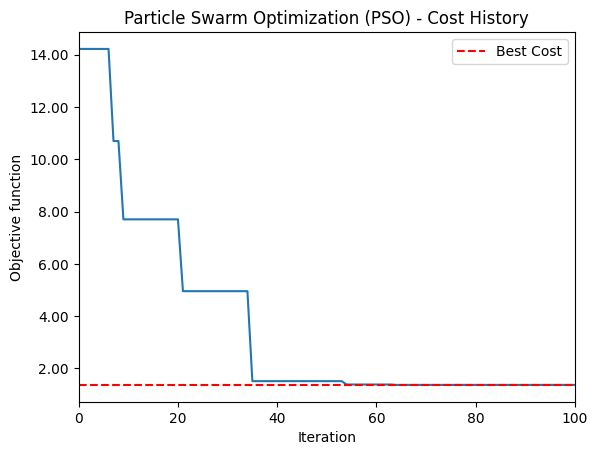

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 136972073.7670715


In [592]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 100000000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost

# Calcular uma margem de segurança (por exemplo, 10%) com base no valor de best_cost
margin = 3 * best_cost

# Definir os limites do eixo y com base no custo ótimo e na margem
y_min = max(optimal_cost - margin, 0)
y_max = optimal_cost + margin

# Encontre o índice correspondente ao custo ótimo
optimal_cost_index = cost_history.index(optimal_cost)

# Configuração do eixo y
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 100000000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)

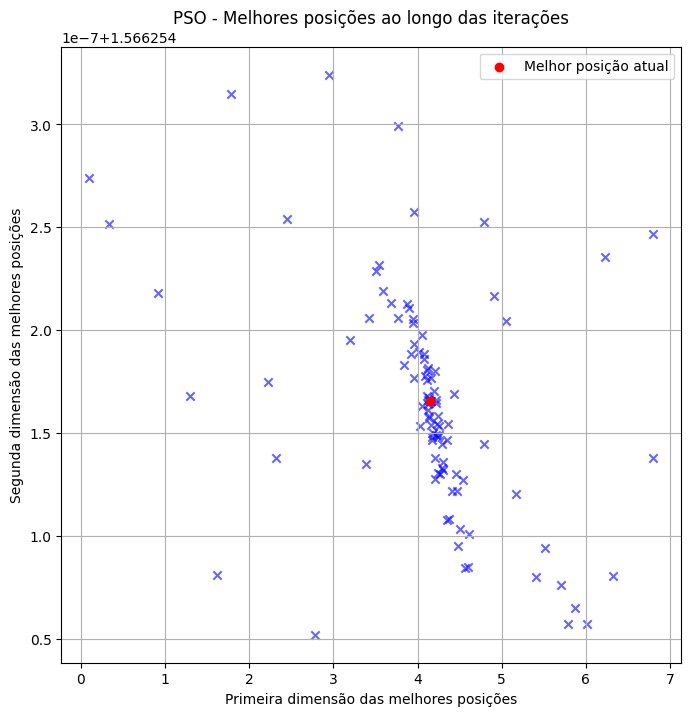

In [594]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [595]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(pbest_cost[0])

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), pbest_cost[0], lamb, beta, theta, num_particles, max_iterations, dimensions, options]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)
